# Step Four (A): Re-Order Candidate Pool via Knowledge Graph Connectivity

In this portion of the pipeline, we take as input a `full_mention` and a list of candidates, apply graph analysis and re-order the likelihoods of a `full_mention==entity_candidate`. The list of candidates can be generated in a number of different ways and can be expanded upon in this portion if the right answer isn't in the initial list.

#### Import Packages

In [1]:
import os
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Progress bar
from tqdm import tqdm

## Integrate Predictions

In [2]:
# Base path to input
preds_path = '../../predictions/'

# Load data
entity_disambiguation = pd.read_csv(os.path.join(preds_path, "wikipedia2vec_most_similar.csv"), delimiter=",")
entity_disambiguation.head(10)

,mention,full_mention,wikipedia_URL,wikipedia_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,preds_w2v_getentity,full_mention_norm,preds_w2v_mostsimilar,score_w2v_mostsimilar,candidate_pool_mostsimilar,candidate_scores_mostsimilar
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",European Union,eu,European Union,0.787421,"['European Union', 'European Free Trade Associ...","[0.7874206, 0.7662648, 0.76082164, 0.76052165,..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",NaN,german,Culture of Germany,0.686803,"['Culture of Germany', '1860 in Germany', '186...","[0.68680257, 0.6840672, 0.6836185, 0.68068546,..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",NaN,british,Russians in the United Kingdom,0.615564,"['Russians in the United Kingdom', 'Henry Wood...","[0.6155642, 0.60587233, 0.6025652, 0.5973172, ..."
3,B,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",NaN,peter blackburn,Russians in the United Kingdom,0.615564,[],[]
4,I,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",NaN,peter blackburn,Russians in the United Kingdom,0.615564,[],[]
5,B,BRUSSELS,http://en.wikipedia.org/wiki/Brussels,3708.0,Brussels,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",NaN,brussels,Brussels,0.887070,"['Brussels', 'Ghent', 'Timeline of Brussels', ...","[0.8870699, 0.7689268, 0.76867557, 0.7681168, ..."
6,B,European Commission,http://en.wikipedia.org/wiki/European_Commission,9974.0,European Commission,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",European Commission,european commission,Brussels,0.887070,[],[]
7,I,European Commission,http://en.wikipedia.org/wiki/European_Commission,9974.0,European Commission,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",European Commission,european commission,Brussels,0.887070,[],[]
8,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",NaN,german,Culture of Germany,0.686803,"['Culture of Germany', '1860 in Germany', '186...","[0.68680257, 0.6840672, 0.6836185, 0.68068546,..."
9,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",NaN,british,Russians in the United Kingdom,0.615564,"['Russians in the United Kingdom', 'Henry Wood...","[0.6155642, 0.60587233, 0.6025652, 0.5973172, ..."


In [26]:
len(entity_disambiguation)

1000

### Parse Saved Candidate Pool

Candidate pools when exported are typically stored as the string of a list. The below function parses the string back into a list with proper formatted values.

In [3]:
# Example
entity_disambiguation['candidate_pool_mostsimilar'][0][2:-2].split("', '")

['European Union',
 'European Free Trade Association',
 'European Economic Area',
 'European Union legislative procedure#Codecision procedure',
 'Directorate-General for Trade',
 'European Union Operations Centre',
 'Development Cooperation Instrument',
 'European Common Aviation Area',
 'European Political Strategy Centre',
 'European Union Global Strategy',
 'Treaties of the European Union',
 'European Defence Fund',
 'Bodies of the European Union',
 'Common commercial policy',
 'Common Foreign and Security Policy\', "European Union\'s scientific cooperation beyond the bloc", \'Small Business Act for Europe',
 'Committee of Permanent Representatives',
 'Treaties of the European Union#Treaty on the functioning of the European Union',
 'Lists of member states of the European Union',
 'Free trade areas in Europe#BAFTA',
 'Member state of the European Union',
 'Acquis communautaire',
 'Directorate-General for External Relations (European Commission)',
 'Directorate-General for Financial 

In [4]:
# Function to parse list as string
def parse_w2v_list(list_string):
    
    parsed_list = []
    
    # If candidate pool is empty
    if list_string == "[]":
        pass
    # Else parse
    else:
        # Eliminate bracket and parenthesis on either side, split by comma pattern
        parsed_list = re.split("', '|\", \"|', \"|\", \'", list_string[2:-2])
        
    return parsed_list


In [5]:
# Manually test function
# 0 is the hard one. See how some value is stored with '' and some with "". Unsure why.
parse_w2v_list(entity_disambiguation['candidate_pool_mostsimilar'][0])

['European Union',
 'European Free Trade Association',
 'European Economic Area',
 'European Union legislative procedure#Codecision procedure',
 'Directorate-General for Trade',
 'European Union Operations Centre',
 'Development Cooperation Instrument',
 'European Common Aviation Area',
 'European Political Strategy Centre',
 'European Union Global Strategy',
 'Treaties of the European Union',
 'European Defence Fund',
 'Bodies of the European Union',
 'Common commercial policy',
 'Common Foreign and Security Policy',
 "European Union's scientific cooperation beyond the bloc",
 'Small Business Act for Europe',
 'Committee of Permanent Representatives',
 'Treaties of the European Union#Treaty on the functioning of the European Union',
 'Lists of member states of the European Union',
 'Free trade areas in Europe#BAFTA',
 'Member state of the European Union',
 'Acquis communautaire',
 'Directorate-General for External Relations (European Commission)',
 'Directorate-General for Financial S

In [6]:
# Apply defined function
parsed_candidate_pool = entity_disambiguation['candidate_pool_mostsimilar'].apply(parse_w2v_list)
entity_disambiguation['candidate_pool_mostsimilar'] = parsed_candidate_pool
entity_disambiguation['candidate_pool_mostsimilar'][:3]

0    [European Union, European Free Trade Associati...
1    [Culture of Germany, 1860 in Germany, 1866 in ...
2    [Russians in the United Kingdom, Henry Wood (n...
Name: candidate_pool_mostsimilar, dtype: object

### Link Page Title to Page ID

Due to our methods of text analysis, we will primarily be receiving Wikipedia Page Titles in our Candidate Pools. In order to use the defined graph, we must find the Wikipedia Page ID.

In [8]:
# Integrate page.csv
page_df = pd.read_csv("../../data/kdkg/page.csv", delimiter=',')
assert type(page_df) is not None
display(page_df.head(3))

,page_id,item_id,title,views
0,12,6199,Anarchism,31335
1,25,38404,Autism,49693
2,39,101038,Albedo,14573


In [14]:
# Test manual search
page_df[page_df['title'] == "Russians in the United Kingdom"]

,page_id,item_id,title,views
1352883,9808786,3308075,Russians in the United Kingdom,684


In [7]:
# Integrate item.csv
item_df = pd.read_csv("../../data/kdkg/item.csv", delimiter=',')
assert type(item_df) is not None
display(item_df.head(3))

,item_id,en_label,en_description
0,1,Universe,totality of space and all contents
1,2,Earth,third planet from the Sun in the Solar System
2,3,life,matter capable of extracting energy from the e...


In [15]:
# Test manual search
item_df[item_df['en_label'] == "Russians in the United Kingdom"]

,item_id,en_label,en_description
2700587,3308075,Russians in the United Kingdom,Ethnic group in the United Kingdom


In [17]:
print("Page Length: {:,}".format(len(page_df)), "Item Length: {:,}".format(len(item_df)))

Page Length: 5,362,174 Item Length: 51,450,316


Using page_df is faster given the relative size (10% of item_df) but it is unable to find a significant amount of item_ids as provided in the candidate pools.

## Process Candidate Pool Titles into Candidate Pool IDs

First, we assess the coverage of our `page.csv` file as a lookup table for candidates in all candidate pools.

Second, we generate processed candidate IDs.

In [23]:
%%time
# Assess coverage of page.csv as lookup table
total_found_candidates = 0
total_candidate_searches = 0
for i in tqdm(range(len(entity_disambiguation))):
    candidate_pool = entity_disambiguation['candidate_pool_mostsimilar'][i]
    found_candidates = (page_df['title'].isin(candidate_pool)).sum()
    total_found_candidates += found_candidates
    total_candidate_searches += len(candidate_pool)
print(f"Of {total_candidate_searches} searches, {round(total_found_candidates/total_candidate_searches*100, 3)}% returned a value.")

100%|██████████| 1000/1000 [01:48<00:00,  9.24it/s]

Of 4106 searches, 82.708% returned a value.
CPU times: user 1min 46s, sys: 1.35 s, total: 1min 47s
Wall time: 1min 48s


In [33]:
%%time
# Assess coverage of item.csv as lookup table
total_found_candidates = 0
total_candidate_searches = 0
for i in tqdm(range(len(entity_disambiguation[:10]))):
    candidate_pool = entity_disambiguation['candidate_pool_mostsimilar'][i]
    found_candidates = (item_df['en_label'].isin(candidate_pool)).sum()
    print(found_candidates,"/", len(candidate_pool))
    total_found_candidates += found_candidates
    total_candidate_searches += len(candidate_pool)
print(f"Of {total_candidate_searches} searches, {round(total_found_candidates/total_candidate_searches*100, 3)}% returned a value.")

 10%|█         | 1/10 [00:11<01:40, 11.18s/it]

19 / 25


 20%|██        | 2/10 [00:15<01:12,  9.04s/it]

1 / 7


 30%|███       | 3/10 [00:17<00:48,  6.96s/it]

2 / 5


 40%|████      | 4/10 [00:18<00:30,  5.08s/it]

0 / 0


 50%|█████     | 5/10 [00:19<00:20,  4.11s/it]

0 / 0


 60%|██████    | 6/10 [00:29<00:23,  5.86s/it]

44 / 11


 70%|███████   | 7/10 [00:37<00:19,  6.53s/it]

0 / 0


 80%|████████  | 8/10 [00:46<00:14,  7.04s/it]

0 / 0


 90%|█████████ | 9/10 [00:47<00:05,  5.42s/it]

1 / 7


100%|██████████| 10/10 [00:53<00:00,  5.37s/it]

2 / 5
Of 60 searches, 115.0% returned a value.
CPU times: user 20.3 s, sys: 27.2 s, total: 47.5 s
Wall time: 53.7 s


In [35]:
item_df[item_df['en_label'] == entity_disambiguation['candidate_pool_mostsimilar'][5][1]]

,item_id,en_label,en_description
1245,1296,Ghent,"city in East Flanders, Belgium"
347204,422885,Ghent,Wikimedia disambiguation page
851590,1012247,Ghent,"town in Carroll County, Kentucky, United States"
1839433,2231485,Ghent,"city in Lyon County, Minnesota, United States"
1958494,2372542,Ghent,town in New York state
2831313,3478333,Ghent,"census-designated place in Raleigh County, Wes..."
4439769,5556226,Ghent,"human settlement in Norfolk, Virginia, United ..."
4439771,5556229,Ghent,NaN
4439772,5556230,Ghent,"unincorporated community in Summit County, Ohio"
11176719,16867736,Ghent,family name


Based on performance of above, item_df searching appears to linearly scale with the number of rows (10x rows, 10x time). It also isn't guaranteed to return a single, correct item_id for the label.....Knowing that, it seems impossible to elect to use item_df without further improvements.

### Get Item IDs

In [36]:
# Define function to take Wikipedia page title and return Wikipedia Item ID and Page ID (todo)
# Using page_df, not item_df
def get_item_id(page_title):
        
    # Retrieve item id from page_df
    try:
        item_id = page_df[page_df['title'] == page_title]['item_id'].values[0]
    #     page_id = page_df[page_df['title'] == page_title]['page_id']
    except IndexError:
        item_id = None
        
    return item_id # todo is there any reason to return page_id?

In [37]:
%%time
# Manually test function
get_item_id(entity_disambiguation['candidate_pool_mostsimilar'][0][0])

CPU times: user 405 ms, sys: 844 ms, total: 1.25 s
Wall time: 1.94 s


458

In [38]:
entity_disambiguation['candidate_pool_mostsimilar'][0]

['European Union',
 'European Free Trade Association',
 'European Economic Area',
 'European Union legislative procedure#Codecision procedure',
 'Directorate-General for Trade',
 'European Union Operations Centre',
 'Development Cooperation Instrument',
 'European Common Aviation Area',
 'European Political Strategy Centre',
 'European Union Global Strategy',
 'Treaties of the European Union',
 'European Defence Fund',
 'Bodies of the European Union',
 'Common commercial policy',
 'Common Foreign and Security Policy',
 "European Union's scientific cooperation beyond the bloc",
 'Small Business Act for Europe',
 'Committee of Permanent Representatives',
 'Treaties of the European Union#Treaty on the functioning of the European Union',
 'Lists of member states of the European Union',
 'Free trade areas in Europe#BAFTA',
 'Member state of the European Union',
 'Acquis communautaire',
 'Directorate-General for External Relations (European Commission)',
 'Directorate-General for Financial S

In [39]:
%%time
# Test function on full list
[get_item_id(i) for i in entity_disambiguation['candidate_pool_mostsimilar'][0]]

CPU times: user 6.74 s, sys: 42.4 ms, total: 6.78 s
Wall time: 6.84 s


[458,
 166546,
 8932,
 None,
 1501745,
 48739380,
 5266679,
 5412411,
 4998373,
 30750657,
 11122,
 47089474,
 4936585,
 55608171,
 672788,
 30687511,
 19309220,
 780116,
 None,
 None,
 None,
 185441,
 256414,
 5280592,
 5280597]

In [40]:
# Shorten larger file into testable 100 row dataframe
mini_df = entity_disambiguation[:100].copy()

In [41]:
# Run over whole dataframe
candidate_pool_ids = []
no_id_match = 0
query_count = 0
for i in tqdm(range(len(mini_df))):
    pool = []
    candidates = mini_df['candidate_pool_mostsimilar'][i]
    for l in candidates:
        item_id = get_item_id(l)
        pool.append(item_id)
        if item_id is None:
            no_id_match += 1
        query_count += 1
    candidate_pool_ids.append(pool)

print("Unable to match known page title with page id: ", round(no_id_match/query_count*100,3),"%")

100%|██████████| 100/100 [01:49<00:00,  1.10s/it]

Unable to match known page title with page id:  25.112 %


In [42]:
candidate_pool_ids[1]

[1979615, 56291039, None, None, None, None, None]

In [43]:
mini_df['candidate_pool_ids'] = candidate_pool_ids
mini_df.head(3)

,mention,full_mention,wikipedia_URL,wikipedia_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,preds_w2v_getentity,full_mention_norm,preds_w2v_mostsimilar,score_w2v_mostsimilar,candidate_pool_mostsimilar,candidate_scores_mostsimilar,candidate_pool_ids
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",European Union,eu,European Union,0.787421,"[European Union, European Free Trade Associati...","[0.7874206, 0.7662648, 0.76082164, 0.76052165,...","[458, 166546, 8932, None, 1501745, 48739380, 5..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",NaN,german,Culture of Germany,0.686803,"[Culture of Germany, 1860 in Germany, 1866 in ...","[0.68680257, 0.6840672, 0.6836185, 0.68068546,...","[1979615, 56291039, None, None, None, None, None]"
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",NaN,british,Russians in the United Kingdom,0.615564,"[Russians in the United Kingdom, Henry Wood (n...","[0.6155642, 0.60587233, 0.6025652, 0.5973172, ...","[3308075, None, None, None, 7785]"


# NetworkX

We use NetworkX as our graph analytic package. The Kensho-derived Knowledge Graph is sufficiently large that we can't generate a graph from the entire thing at once. Instead, we will pass in the congruent entities, retrieve N degree links and todo ......

In [44]:
# Import NetworkX
import networkx as nx

# TODO - what to do with graph?

#### Ingest KD Statements

Our graph is based on relationships defined by Kensho in the statements.csv file. We integrate it below.

In [13]:
# Integrate statements.csv
statements_df = pd.read_csv("../../data/kdkg/statements.csv", delimiter=',')
assert type(statements_df) is not None
display(statements_df.head(3))

,source_item_id,edge_property_id,target_item_id
0,1,31,36906466
1,1,279,3695190
2,1,398,497745


## Get First-Degree Connections from an Item ID

In [45]:
##################################################
### Function to Retrieve First-Degree Page Connections
##################################################
def get_page_links(source_item_id, verbose=False):
    """
    This function asks you to enter an Item ID for a page and
    will retrieve a list of all first-degree linked page IDs it can find.
    Inputs:
    - source_item_id: The Item ID you want to start from
    Note: Must have page.csv and statements.csv integrated beforehand.
    """
    # Break if source_item_id entered during iteration is None
    if source_item_id is None:
        if verbose: print("Unable to find page for linking")
        return []
    
    if verbose:
        # Retrieve Page Title for Status Printing
        source_page_title = page_df[page_df['item_id'] == source_item_id]['title'].item()
        print(f"Linking from page \"{source_page_title}\"")
    
    # Return all statements linking source_item_id to other pages
    source_page_connections = statements_df[statements_df['source_item_id'] == source_item_id]
    if verbose: print(f"Found {len(source_page_connections)} linked items by property. Sample below.")
    
    # Return array of all linked Item IDs
    linked_item_ids = np.array(source_page_connections['target_item_id'])
    
    # Return all linked pages for these item IDs
    linked_page_ids = []
    for i in linked_item_ids:
        try:
            linked_page_ids.append(page_df[page_df['item_id'] == i]['page_id'].item())
        except:
            continue
    if verbose: print(f"We were able to link {len(linked_page_ids)} out of {len(linked_item_ids)} Item IDs back to a Page ID (Entity).")

    return linked_page_ids

In [46]:
page_df[page_df['item_id'] == 3308075]['title']

1352883    Russians in the United Kingdom
Name: title, dtype: object

In [47]:
# Manual test with a page ID
get_page_links(3308075, verbose=True)

Linking from page "Russians in the United Kingdom"
Found 4 linked items by property. Sample below.
We were able to link 4 out of 4 Item IDs back to a Page ID (Entity).


[31717, 105004, 59510, 25431]

In [48]:
# Manual test with None
get_page_links(None, verbose=True)

Unable to find page for linking


[]

## Assess Response Coverage If Expanding Candidate Pool to First-Degree Connected Pages

In [49]:
# Testing with candidate pool
idx = 1
print(mini_df['candidate_pool_mostsimilar'][idx])
print(mini_df['candidate_pool_ids'][idx])
# Iterate over manually chosen single candidate pool to expand to first degree connections
expanded_candidate_pool = []
for candidate_id in mini_df['candidate_pool_ids'][idx]:
    D1_candidates = get_page_links(candidate_id, verbose=True)
    for new_candidate in D1_candidates:
        expanded_candidate_pool.append(new_candidate)
    print(D1_candidates)

['Culture of Germany', '1860 in Germany', '1866 in Germany', 'Template:Focke-Wulf aircraft', '1847 in Germany', 'File:Map-GermanConfederation.svg', '1858 in Germany']
[1979615, 56291039, None, None, None, None, None]
Linking from page "Culture of Germany"
Found 3 linked items by property. Sample below.
We were able to link 1 out of 3 Item IDs back to a Page ID (Entity).
[11867]
Linking from page "1860 in Germany"
Found 2 linked items by property. Sample below.
We were able to link 0 out of 2 Item IDs back to a Page ID (Entity).
[]
Unable to find page for linking
[]
Unable to find page for linking
[]
Unable to find page for linking
[]
Unable to find page for linking
[]
Unable to find page for linking
[]


In [50]:
# Print expanded pool
expanded_candidate_pool

[11867]

In [51]:
# Expand all candidate pools to 1-Degree
expanded_candidate_pool_ids = []

# For every candidate pool
for candidate_pool_ids in tqdm(mini_df['candidate_pool_ids']):
    expanded_candidate_pool = []
    # For every candidate ID in a particular pool
    for candidate_id in candidate_pool_ids:
        # Get first-degree page links that can be matched
        D1_candidates = get_page_links(candidate_id, verbose=False)
        # Add new candidates to expanded pool
        for new_candidate in D1_candidates:
            expanded_candidate_pool.append(new_candidate)
    # Save old and new candidate list
    expanded_candidate_pool_ids.append(candidate_pool_ids + expanded_candidate_pool)

# Add to dataframe
mini_df['expanded_candidate_pool_ids'] = expanded_candidate_pool_ids
mini_df.head(3)

100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


,mention,full_mention,wikipedia_URL,wikipedia_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,preds_w2v_getentity,full_mention_norm,preds_w2v_mostsimilar,score_w2v_mostsimilar,candidate_pool_mostsimilar,candidate_scores_mostsimilar,candidate_pool_ids,expanded_candidate_pool_ids
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",European Union,eu,European Union,0.787421,"[European Union, European Free Trade Associati...","[0.7874206, 0.7662648, 0.76082164, 0.76052165,...","[458, 166546, 8932, None, 1501745, 48739380, 5...","[458, 166546, 8932, None, 1501745, 48739380, 5..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",NaN,german,Culture of Germany,0.686803,"[Culture of Germany, 1860 in Germany, 1866 in ...","[0.68680257, 0.6840672, 0.6836185, 0.68068546,...","[1979615, 56291039, None, None, None, None, None]","[1979615, 56291039, None, None, None, None, No..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",NaN,british,Russians in the United Kingdom,0.615564,"[Russians in the United Kingdom, Henry Wood (n...","[0.6155642, 0.60587233, 0.6025652, 0.5973172, ...","[3308075, None, None, None, 7785]","[3308075, None, None, None, 7785, 31717, 10500..."


### Generate expanded candidate pool of page titles to assess presence

In [52]:
# Define function to take Wikipedia page item ID and return Wikipedia title
def get_page_title(item_id):
        
    # Retrieve page title from page_df
    try:
        page_title = page_df[page_df['item_id'] == item_id]['title'].values[0]
    except IndexError:
        page_title = None
        
    return page_title

In [54]:
# Manually test function
for i in mini_df['expanded_candidate_pool_ids'][1]:
    print(get_page_title(i))

Culture of Germany
1860 in Germany
None
None
None
None
None
1984 European Parliament election in Italy


In [55]:
# Apply to all expanded_candidate_pool_ids
expanded_candidate_pool_mostsimilar = []

# For every candidate pool
for candidate_pool_ids in tqdm(mini_df['expanded_candidate_pool_ids']):
    candidate_pool_titles = []
    # For every candidate ID in a particular pool
    for candidate_id in candidate_pool_ids:
        candidate_pool_titles.append(get_page_title(candidate_id))
    expanded_candidate_pool_mostsimilar.append(candidate_pool_titles)
    
# Add to dataframe
mini_df['expanded_candidate_pool_mostsimilar'] = expanded_candidate_pool_mostsimilar
mini_df.head(3)

100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


,mention,full_mention,wikipedia_URL,wikipedia_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,preds_w2v_getentity,full_mention_norm,preds_w2v_mostsimilar,score_w2v_mostsimilar,candidate_pool_mostsimilar,candidate_scores_mostsimilar,candidate_pool_ids,expanded_candidate_pool_ids,expanded_candidate_pool_mostsimilar
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",European Union,eu,European Union,0.787421,"[European Union, European Free Trade Associati...","[0.7874206, 0.7662648, 0.76082164, 0.76052165,...","[458, 166546, 8932, None, 1501745, 48739380, 5...","[458, 166546, 8932, None, 1501745, 48739380, 5...","[European Union, European Free Trade Associati..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",NaN,german,Culture of Germany,0.686803,"[Culture of Germany, 1860 in Germany, 1866 in ...","[0.68680257, 0.6840672, 0.6836185, 0.68068546,...","[1979615, 56291039, None, None, None, None, None]","[1979615, 56291039, None, None, None, None, No...","[Culture of Germany, 1860 in Germany, None, No..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",NaN,british,Russians in the United Kingdom,0.615564,"[Russians in the United Kingdom, Henry Wood (n...","[0.6155642, 0.60587233, 0.6025652, 0.5973172, ...","[3308075, None, None, None, 7785]","[3308075, None, None, None, 7785, 31717, 10500...","[Russians in the United Kingdom, None, None, N..."


In [56]:
# Calculate percentage of candidate pools with the correct answer present
# Measuring against Wikipedia titles
# Necessary to determine if shuffling pool could even get the right answer
response_present = [mini_df['wikipedia_title'][i] in mini_df['expanded_candidate_pool_mostsimilar'][i] for i in range(len(mini_df))]
print(f"Correct answer is present in {round(sum(response_present) / len(mini_df) * 100, 3)}% of expanded candidate pools via adapted Wikipedia2vec's most_similar() method.")

Correct answer is present in 18.0% of expanded candidate pools via adapted Wikipedia2vec's most_similar() method.


In [57]:
# Calculate percentage of candidate pools with the correct answer present
# Measuring against Wikipedia IDs found from page_df
# Necessary to determine if shuffling pool could even get the right answer

response_present = [mini_df['wikipedia_ID'][i] in mini_df['candidate_pool_ids'][i] for i in range(len(mini_df))]
print(f"Correct answer is present in {round(sum(response_present) / len(mini_df) * 100, 3)}% of expanded candidate pools via adapted Wikipedia2vec's most_similar() method.")


response_present = [mini_df['wikipedia_ID'][i] in mini_df['expanded_candidate_pool_ids'][i] for i in range(len(mini_df))]
print(f"Correct answer is present in {round(sum(response_present) / len(mini_df) * 100, 3)}% of expanded candidate pools via adapted Wikipedia2vec's most_similar() method.")

Correct answer is present in 0.0% of expanded candidate pools via adapted Wikipedia2vec's most_similar() method.
Correct answer is present in 31.0% of expanded candidate pools via adapted Wikipedia2vec's most_similar() method.


Using matcheable first-degree connections, this represents a decrease in coverage due to the transformation through the statements.csv file. We must convert title from get_entity() into an item id using KDWD, then expand to other item ids using statements.csv (since only IDs represent relationships), then translate BACK to titles from IDs before comparing against response.

In [60]:
##################################################
### Function to Retrieve Second-Degree Page Connections
##################################################
def get_ND_page_links(source_item_id, N=2, verbose=False):
    """
    This function asks you to enter an Item ID for a page and
    will retrieve a list of all first- and second-degree linked page IDs it can find.
    Inputs:
    - source_item_id: The Item ID you want to start from
    Note: Must have page.csv and statements.csv integrated beforehand.
    """
    # Break if source_item_id entered during iteration is None
    if source_item_id is None:
        if verbose: print("Unable to find page for linking")
        return []
    
    if verbose:
        # Retrieve Page Title for Status Printing
        source_page_title = page_df[page_df['item_id'] == source_item_id]['title'].item()
        print(f"Linking from page \"{source_page_title}\"")
    

    
    # Keep track of metrics
    n = 0
    source_page_total_connections = [source_item_id]
    start = 0
    end = len(source_page_total_connections)
    if verbose: print(n, start, end)
    
    while n < N:
        for source_id in source_page_total_connections[start:end]:
            
            # Return all statements linking source_item_id to other pages
            source_page_connections = statements_df[statements_df['source_item_id'] == source_id]

            # Return array of all linked Item IDs
            linked_item_ids = source_page_connections['target_item_id']
            
            # Save list
            for connection in linked_item_ids:
                source_page_total_connections.append(connection)
    
        # Increment
        n += 1
        start = end
        end = len(source_page_total_connections)
        if verbose: print(n, start, end)
    
    
    if verbose: print(f"Found {len(source_page_total_connections)} {N}-Degree linked items by property. Sample below.")
        
    # Return all linked pages for these item IDs
    linked_item_ids = np.array(source_page_total_connections)
    linked_page_ids = []
    for i in linked_item_ids:
        try:
            linked_page_ids.append(page_df[page_df['item_id'] == i]['page_id'].item())
        except:
            continue
    if verbose: print(f"We were able to link {len(linked_page_ids)} out of {len(linked_item_ids)} Item IDs back to a Page ID (Entity).")

    return linked_page_ids

In [61]:
# Manual test with a page ID
output = get_ND_page_links(3308075, N=2, verbose=True)

Linking from page "Russians in the United Kingdom"
0 0 1
1 1 5
2 5 410
Found 410 2-Degree linked items by property. Sample below.
We were able to link 349 out of 410 Item IDs back to a Page ID (Entity).


In [62]:
# Manual test with None
get_ND_page_links(None, N=2, verbose=True)

Unable to find page for linking


[]

In [63]:
# Expand all candidate pools to 2-Degree
expanded_candidate_pool_ids = []

# For every candidate pool
for candidate_pool_ids in tqdm(mini_df['candidate_pool_ids']):
    expanded_candidate_pool = []
    # For every candidate ID in a particular pool
    for candidate_id in candidate_pool_ids:
        # Get first-degree page links that can be matched
        D1_candidates = get_ND_page_links(candidate_id, N=2, verbose=False)
        # Add new candidates to expanded pool
        for new_candidate in D1_candidates:
            expanded_candidate_pool.append(new_candidate)
    # Save old and new candidate list
    expanded_candidate_pool_ids.append(candidate_pool_ids + expanded_candidate_pool)

# Add to dataframe
mini_df['expanded_candidate_pool_ids'] = expanded_candidate_pool_ids
mini_df.head(3)

100%|██████████| 100/100 [1:23:37<00:00, 50.18s/it]  


,mention,full_mention,wikipedia_URL,wikipedia_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,preds_w2v_getentity,full_mention_norm,preds_w2v_mostsimilar,score_w2v_mostsimilar,candidate_pool_mostsimilar,candidate_scores_mostsimilar,candidate_pool_ids,expanded_candidate_pool_ids,expanded_candidate_pool_mostsimilar
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",European Union,eu,European Union,0.787421,"[European Union, European Free Trade Associati...","[0.7874206, 0.7662648, 0.76082164, 0.76052165,...","[458, 166546, 8932, None, 1501745, 48739380, 5...","[458, 166546, 8932, None, 1501745, 48739380, 5...","[European Union, European Free Trade Associati..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",NaN,german,Culture of Germany,0.686803,"[Culture of Germany, 1860 in Germany, 1866 in ...","[0.68680257, 0.6840672, 0.6836185, 0.68068546,...","[1979615, 56291039, None, None, None, None, None]","[1979615, 56291039, None, None, None, None, No...","[Culture of Germany, 1860 in Germany, None, No..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",NaN,british,Russians in the United Kingdom,0.615564,"[Russians in the United Kingdom, Henry Wood (n...","[0.6155642, 0.60587233, 0.6025652, 0.5973172, ...","[3308075, None, None, None, 7785]","[3308075, None, None, None, 7785, 9808786, 317...","[Russians in the United Kingdom, None, None, N..."


In [64]:
# Apply to all 2-D expanded_candidate_pool_ids
expanded_candidate_pool_mostsimilar = []

# For every candidate pool
for candidate_pool_ids in tqdm(mini_df['expanded_candidate_pool_ids']):
    candidate_pool_titles = []
    # For every candidate ID in a particular pool
    for candidate_id in candidate_pool_ids:
        candidate_pool_titles.append(get_page_title(candidate_id))
    expanded_candidate_pool_mostsimilar.append(candidate_pool_titles)
    
# Add to dataframe
mini_df['expanded_candidate_pool_mostsimilar'] = expanded_candidate_pool_mostsimilar
mini_df.head(3)

100%|██████████| 100/100 [39:57<00:00, 23.98s/it] 


,mention,full_mention,wikipedia_URL,wikipedia_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,preds_w2v_getentity,full_mention_norm,preds_w2v_mostsimilar,score_w2v_mostsimilar,candidate_pool_mostsimilar,candidate_scores_mostsimilar,candidate_pool_ids,expanded_candidate_pool_ids,expanded_candidate_pool_mostsimilar
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",European Union,eu,European Union,0.787421,"[European Union, European Free Trade Associati...","[0.7874206, 0.7662648, 0.76082164, 0.76052165,...","[458, 166546, 8932, None, 1501745, 48739380, 5...","[458, 166546, 8932, None, 1501745, 48739380, 5...","[European Union, European Free Trade Associati..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",NaN,german,Culture of Germany,0.686803,"[Culture of Germany, 1860 in Germany, 1866 in ...","[0.68680257, 0.6840672, 0.6836185, 0.68068546,...","[1979615, 56291039, None, None, None, None, None]","[1979615, 56291039, None, None, None, None, No...","[Culture of Germany, 1860 in Germany, None, No..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",NaN,british,Russians in the United Kingdom,0.615564,"[Russians in the United Kingdom, Henry Wood (n...","[0.6155642, 0.60587233, 0.6025652, 0.5973172, ...","[3308075, None, None, None, 7785]","[3308075, None, None, None, 7785, 9808786, 317...","[Russians in the United Kingdom, None, None, N..."


In [65]:
# Calculate percentage of candidate pools with the correct answer present
# Necessary to determine if shuffling pool could even get the right answer
response_present = [mini_df['wikipedia_title'][i] in\
                    mini_df['expanded_candidate_pool_mostsimilar'][i]\
                    for i in range(len(mini_df))]
print(f"Correct answer is present in {round(sum(response_present) / len(mini_df) * 100, 3)}% of expanded candidate pools via adapted Wikipedia2vec's most_similar() method.")

Correct answer is present in 18.0% of expanded candidate pools via adapted Wikipedia2vec's most_similar() method.


In [67]:
# Calculate percentage of candidate pools with the correct answer present
# Measuring against Wikipedia IDs found from page_df
# Necessary to determine if shuffling pool could even get the right answer

response_present = [mini_df['wikipedia_ID'][i] in mini_df['candidate_pool_ids'][i] for i in range(len(mini_df))]
print(f"Correct answer is present in {round(sum(response_present) / len(mini_df) * 100, 3)}% of expanded candidate pools via adapted Wikipedia2vec's most_similar() method.")


response_present = [mini_df['wikipedia_ID'][i] in mini_df['expanded_candidate_pool_ids'][i] for i in range(len(mini_df))]
print(f"Correct answer is present in {round(sum(response_present) / len(mini_df) * 100, 3)}% of expanded candidate pools via adapted Wikipedia2vec's most_similar() method.")

Correct answer is present in 0.0% of expanded candidate pools via adapted Wikipedia2vec's most_similar() method.
Correct answer is present in 35.0% of expanded candidate pools via adapted Wikipedia2vec's most_similar() method.


In [66]:
# Save dataframe at this step
mini_df.to_csv(os.path.join(preds_path, "networkx_expanded_pool.csv"), index=False)

### Plot Graph of Candidates and First-Degree Connections

In [252]:
###########################################################
### Function to Create Graph from Source Node to N Degree
###########################################################
def network_to_n_degree(network_seeds, N=2, plot_node_growth=False):
    """
    This function asks you to enter an Item ID or a list of Item IDs and will return a constructed graph to N degrees
    It includes a number of performance metrics like node growth and search time
    Inputs:
    - source_item_id: single digit or list/array to seed the graph
    - N: Number of degrees to which we should search
    Outputs:
    - NetworkX Graph object
    Note: Requires previous import of statements_df
    """
    
    if not isinstance(network_seeds, (list, np.ndarray)):
        network_seeds = [network_seeds]
        
    if plot_node_growth:
        plt.figure(figsize=(10,4))
        plt.title("Node Growth By Degree")
        plt.xlabel("Degrees")
        plt.ylabel("Count of Nodes")
        
    
    network_edgelist = pd.DataFrame(columns=statements_df.columns)
    
    for seed in network_seeds:
        
        print("*********************")
        print("Searching for seed {}".format(seed))

        # Return First Degree Connections to seed edge list
        print("Calculating Degree 1 Connections")
        start_time = time.time()
        first_degree_connections = statements_df[statements_df['source_item_id'] == seed]
        connections_list = first_degree_connections['target_item_id']

        # Keep track of metrics
        start = 0
        end = len(connections_list)
        node_counts = [1]
        node_counts.append(len(connections_list))
        print("Degree took {}s to compute for {} nodes".format(round(time.time()-start_time,1), end-start))

        # For N degrees, loop over connections and return
        for i in range(2, N+1):
            start_time = time.time()
            print("Calculating Degree {} connections".format(i))
    #         print(start, end)
            for item in connections_list[start:end]:
    #             print(item)
                Nth_degree_connections = statements_df[statements_df['source_item_id'] == item]
                first_degree_connections = first_degree_connections.append(Nth_degree_connections)
                if i <= N:
                    connections_list = connections_list.append(Nth_degree_connections['target_item_id'])
            start = end
            end = len(connections_list)
            if plot_node_growth:
                node_counts.append(len(connections_list))
            print("Degree took {}s to compute for {} nodes".format(round(time.time()-start_time,1), end-start))
        
        
        # Add to returned dataframe
        network_edgelist = network_edgelist.append(first_degree_connections)

        if plot_node_growth:
            plt.plot(range(N+1), node_counts, lw=3, label=seed)
            
    
    if plot_node_growth:
        plt.legend()
        plt.show()
    
    # Create NetworkX Graph object from DataFrame
    G = nx.from_pandas_edgelist(network_edgelist,
                                     source="source_item_id", target="target_item_id",
                                     edge_attr=True, create_using = nx.MultiGraph())
    
    return G
        

In [285]:
print("******Testing with this Candidate Pool***********")
choice = 2
print(entity_disambiguation['candidate_pool_mostsimilar'][choice])

******Testing with this Candidate Pool***********
['Brussels', 'Ghent', 'Timeline of Brussels', 'Brussels National Airport railway station', 'Liège', 'Ixelles', 'City of Brussels', 'Brussels-Congress railway station', 'Mechelen', 'Leuven', 'Auderghem']


*********************
Searching for seed 240
Calculating Degree 1 Connections
Degree took 0.2s to compute for 48 nodes
*********************
Searching for seed 1296
Calculating Degree 1 Connections
Degree took 0.2s to compute for 58 nodes
*********************
Searching for seed 669962
Calculating Degree 1 Connections
Degree took 0.2s to compute for 2 nodes
*********************
Searching for seed 852880
Calculating Degree 1 Connections
Degree took 0.2s to compute for 12 nodes
*********************
Searching for seed 3992
Calculating Degree 1 Connections
Degree took 0.2s to compute for 87 nodes
*********************
Searching for seed 208713
Calculating Degree 1 Connections
Degree took 0.2s to compute for 19 nodes
*********************
Searching for seed 239
Calculating Degree 1 Connections
Degree took 0.2s to compute for 79 nodes
*********************
Searching for seed 2201793
Calculating Degree 1 Connections
Degree took 0.2s to compute for 12 nodes
*********************
Searching fo

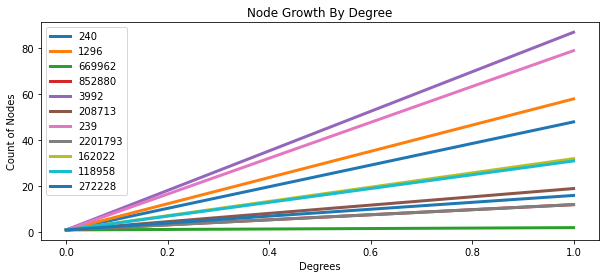

CPU times: user 1.87 s, sys: 561 ms, total: 2.43 s
Wall time: 2.43 s


In [286]:
%%time
# Test with seeds
seed_list = entity_disambiguation['candidate_pool_ids'][choice]
N_degree_G = network_to_n_degree(seed_list, N=1, plot_node_growth=True)

In [287]:
# Print number of nodes in graph
print("Number of nodes: ", N_degree_G.number_of_nodes())
print("Number of links: ", N_degree_G.number_of_edges())

Number of nodes:  327
Number of links:  396


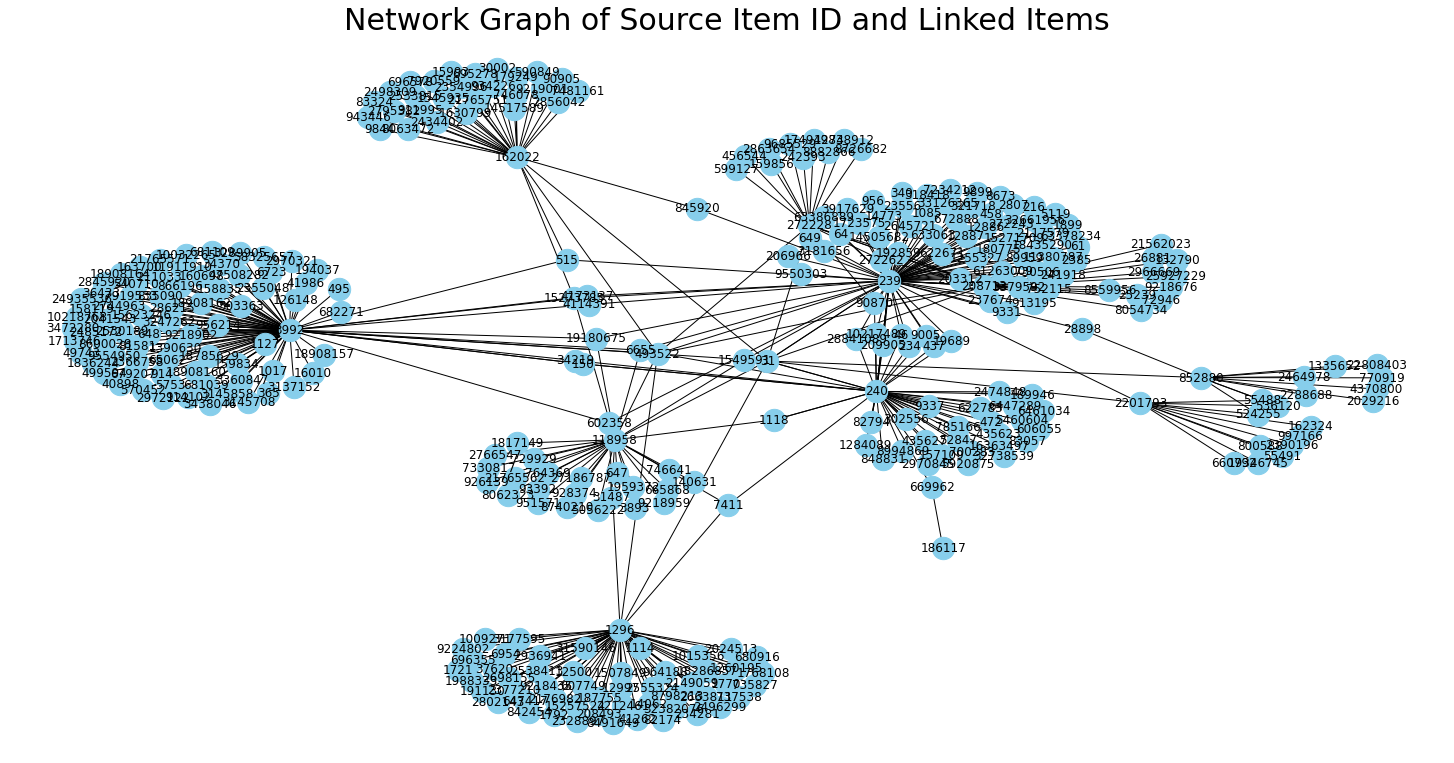

CPU times: user 1.18 s, sys: 262 ms, total: 1.45 s
Wall time: 1.45 s


In [288]:
%%time
# Display filtered network graph for our source page
plt.figure(figsize=(20,10))
pos = nx.spring_layout(N_degree_G, k = 0.1) # k regulates the distance between nodes
nx.draw(N_degree_G, with_labels=True, node_color='skyblue', node_size=500, edge_cmap=plt.cm.Blues, pos=pos)
plt.title("Network Graph of Source Item ID and Linked Items", size=30)
plt.show()